In [1]:
from __future__ import annotations

from pathlib import Path

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


from typing import TYPE_CHECKING

if TYPE_CHECKING:
    import ddpm_model

In [2]:
try:
    from google.colab import drive
    import os

    drive.mount("/content/drive")
    os.chdir("/content/drive/MyDrive/Colab Notebooks")
except ImportError:
    print("Running locally.")

assert Path("ddpm_models").exists(), "Couldn't find model folder"

Running locally.


In [3]:
# Parameters
T = 1000
batch_size = 256

In [4]:
# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(
            lambda x: x + torch.rand(x.shape) / 255
        ),  # Dequantize pixel values
        transforms.Lambda(lambda x: (x - 0.5) * 2.0),  # Map from [0,1] -> [-1, -1]
        transforms.Lambda(lambda x: x.flatten()),
    ]
)

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST("./mnist_data", download=True, train=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

In [5]:
# Select device
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.mps.is_available():
    device = "mps:0"
else:
    device = "cpu"

print(f"Running on {device}")

Running on mps:0


In [6]:
model: ddpm_model.DDPM = torch.load(
    "ddpm_models/variance_importance-batch.pt", weights_only=False, map_location=device
)
model

DDPM(
  (_network): ScoreNet(
    (embed): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (dense1): Dense(
      (dense): Linear(in_features=256, out_features=32, bias=True)
    )
    (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense2): Dense(
      (dense): Linear(in_features=256, out_features=64, bias=True)
    )
    (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense3): Dense(
      (dense): Linear(in_features=256, out_features=128, bias=True)
    )
    (gnorm3): GroupNorm(32, 128, eps=1e-05, affine=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense4): Dense(
      (dense): Linear(in_features=256, out_features=256, bias=

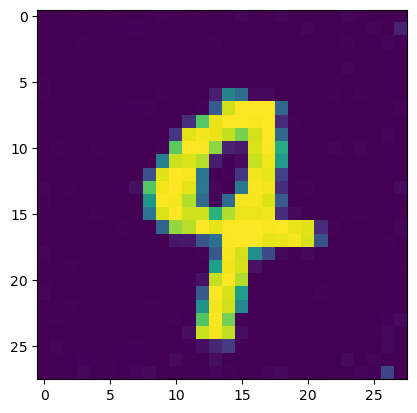

In [7]:
torch.manual_seed(1)
ex_img = model.sample((2, 28 * 28))
plt.imshow(ex_img[0].reshape(28, 28).cpu(), vmin=-1, vmax=1)